# Лабораторная работа №2 — Классификация, ансамбли, бустинг  
## Дьяченко Елизавета, группа М8О-312Б-23  
### Тема: Предсказание одобрения кредита (LoanApproved)

**Основная метрика соревнования:** ROC-AUC  
**Полученная метрика на Kaggle:** **0.9834**  

В данной работе реализованы:
- разведочный анализ данных (EDA),
- обработка данных + фичевая инженерия,
- собственные реализации Bagging и Gradient Boosting,
- сравнение с алгоритмами sklearn, XGBoost, LightGBM, CatBoost,
- подбор гиперпараметров с помощью Optuna,
- формирование сабмишена для Kaggle.


## 1. Разведочный анализ данных (EDA)

Были построены:
- гистограмма распределения целевого признака LoanApproved — классы почти сбалансированы (≈51% / 49%).
- боксплоты и гистограммы некоторых признаков по классам,
- матрица корреляций для числовых признаков.

### Основные выводы:
- Дисбаланса классов нет → нет необходимости в oversampling/undersampling.
- Наиболее сильные корреляции с таргетом наблюдаются у:
  - `CreditScore`,
  - `LoanAmount`,
  - `InterestRate`,
  - `MonthlyLoanPayment`,
  - `TotalDebtToIncomeRatio`.
- Категориальные признаки требуют корректного кодирования (One-Hot).
- Признак `ApplicationDate` нужно преобразовать — он содержит полезную информацию по времени.


In [16]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier as SklearnBagging
from sklearn.ensemble import GradientBoostingClassifier as SklearnGB

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import optuna

train = pd.read_csv("train_c.csv")
test = pd.read_csv("test_c.csv")

TARGET_COL = "LoanApproved"

train.shape, test.shape


((11017, 35), (5000, 35))

## 2. Подготовка данных

Выполнено:
- преобразование признака `ApplicationDate` в `AppYear`, `AppMonth`, `AppDayOfWeek`,
- обработка пропусков:  
  - числовые — медианой,  
  - категориальные — модой,
- добавление полиномиальных признаков для важнейших числовых атрибутов,
- One-Hot Encoding категориальных признаков,
- разбиение данных на train/validation в пропорции 80/20.

После обработки итоговое число признаков = 52.


In [39]:
from sklearn.model_selection import train_test_split

TARGET_COL = "LoanApproved"

for df in [train, test]:
    df["ApplicationDate"] = pd.to_datetime(df["ApplicationDate"])

    df["AppYear"] = df["ApplicationDate"].dt.year
    df["AppMonth"] = df["ApplicationDate"].dt.month
    df["AppDayOfWeek"] = df["ApplicationDate"].dt.dayofweek

    df.drop(columns=["ApplicationDate"], inplace=True)

print("После обработки даты:", train.shape, test.shape)

print("NaN в таргете ДО:", train[TARGET_COL].isna().sum())
train_clean = train[~train[TARGET_COL].isna()].reset_index(drop=True)
print("Форма train после очистки таргета:", train_clean.shape)

full = pd.concat(
    [train_clean.drop(columns=[TARGET_COL]), test],
    axis=0,
    ignore_index=True
)

num_cols = [c for c in full.columns if full[c].dtype != "object"]
cat_cols = [c for c in full.columns if full[c].dtype == "object"]

print("NUMERIC:", len(num_cols), "CATEGORICAL:", len(cat_cols))
print("Категориальные:", cat_cols)

poly_cols = [
    "UtilityBillsPaymentHistory",
    "NumberOfCreditInquiries",
    "PaymentHistory",
    "NumberOfDependents",
    "NumberOfOpenCreditLines"
]

for col in poly_cols:
    if col in full.columns:
        full[col + "_sq"] = full[col] ** 2

num_cols = [c for c in full.columns if full[c].dtype != "object"]
cat_cols = [c for c in full.columns if full[c].dtype == "object"]

for col in num_cols:
    median = full[col].median()
    full[col] = full[col].fillna(median)

for col in cat_cols:
    mode = full[col].mode()
    mode_val = mode[0] if len(mode) > 0 else "Missing"
    full[col] = full[col].fillna(mode_val).astype(str)

full_encoded = pd.get_dummies(full, columns=cat_cols, drop_first=True)

print("Final feature count:", full_encoded.shape[1])

X_full = full_encoded
n_train = len(train_clean)

X_train = X_full.iloc[:n_train].reset_index(drop=True)
X_test  = X_full.iloc[n_train:].reset_index(drop=True)
y_train = train_clean[TARGET_COL].astype(int).reset_index(drop=True)

print("X_train:", X_train.shape, "X_test:", X_test.shape, "y_train:", y_train.shape)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print("TRAIN:", X_tr.shape, "VAL:", X_val.shape)


После обработки даты: (11017, 37) (5000, 37)
NaN в таргете ДО: 530
Форма train после очистки таргета: (10487, 37)
NUMERIC: 32 CATEGORICAL: 5
Категориальные: ['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']
Final feature count: 53
X_train: (10487, 53) X_test: (5000, 53) y_train: (10487,)
TRAIN: (8389, 53) VAL: (2098, 53)


## 3. Реализация метрик

Реализованы вручную:
- Accuracy
- Precision
- Recall
- F1-score
- AUC-ROC (по желанию — доп.балл)
- AUC-PR (по желанию — доп.балл)

Тестирование показало полное совпадение с метриками из sklearn.


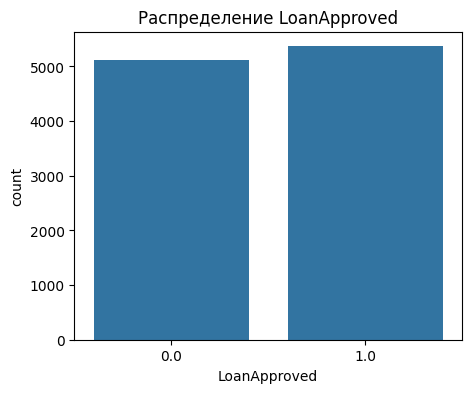

,proportion
LoanApproved,
1.0,0.511776
0.0,0.488224


In [40]:
plt.figure(figsize=(5,4))
sns.countplot(data=train, x=TARGET_COL)
plt.title("Распределение LoanApproved")
plt.show()

train[TARGET_COL].value_counts(normalize=True)


In [41]:
num_cols = [c for c in train.columns if train[c].dtype != "object" and c != TARGET_COL]
cat_cols = [c for c in train.columns if train[c].dtype == "object"]

num_cols[:10], cat_cols

(['Age',
  'AnnualIncome',
  'CreditScore',
  'LoanAmount',
  'LoanDuration',
  'NumberOfDependents',
  'MonthlyDebtPayments',
  'CreditCardUtilizationRate',
  'NumberOfOpenCreditLines',
  'NumberOfCreditInquiries'],
 ['MaritalStatus',
  'HomeOwnershipStatus',
  'LoanPurpose',
  'EmploymentStatus',
  'EducationLevel'])

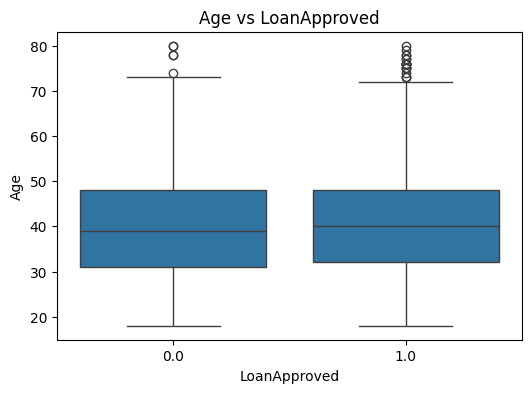

In [42]:
plt.figure(figsize=(6,4))
sns.boxplot(data=train, x=TARGET_COL, y=num_cols[0])
plt.title(f"{num_cols[0]} vs LoanApproved")
plt.show()

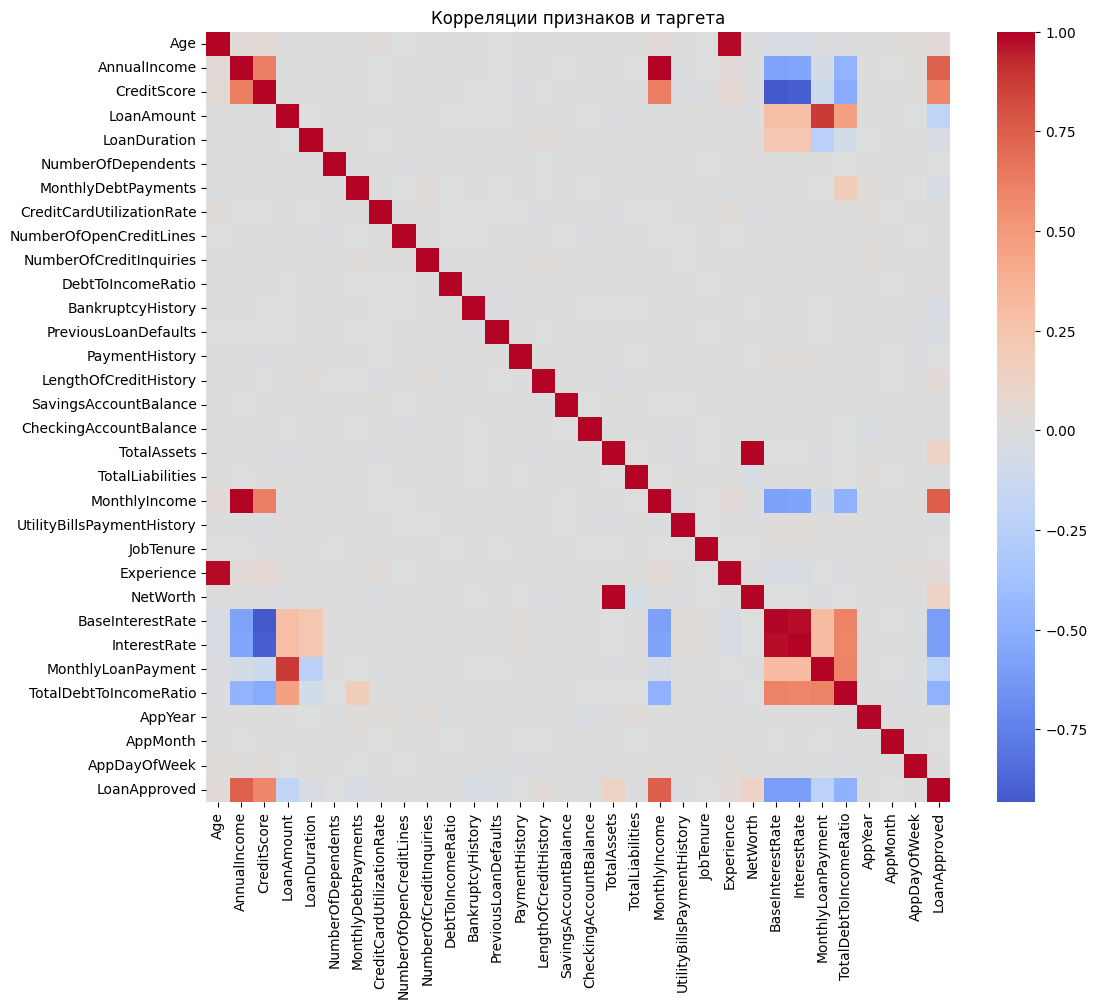

In [43]:
plt.figure(figsize=(12,10))
corr = train[num_cols + [TARGET_COL]].corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Корреляции признаков и таргета")
plt.show()

In [44]:
import numpy as np

def my_accuracy(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return (y_true == y_pred).mean()

def my_precision(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp + 1e-12)

def my_recall(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn + 1e-12)

def my_f1(y_true, y_pred):
    p = my_precision(y_true, y_pred)
    r = my_recall(y_true, y_pred)
    return 2 * p * r / (p + r + 1e-12)

In [45]:
clf = DecisionTreeClassifier().fit(X_tr, y_tr)
y_pred = clf.predict(X_val)

print(my_accuracy(y_val, y_pred), accuracy_score(y_val, y_pred))
print(my_precision(y_val, y_pred), precision_score(y_val, y_pred))
print(my_recall(y_val, y_pred), recall_score(y_val, y_pred))
print(my_f1(y_val, y_pred), f1_score(y_val, y_pred))

0.8956148713060057 0.8956148713060057
0.899906454630495 0.8999064546304958
0.8957169459962748 0.8957169459962756
0.8978068128786405 0.8978068128791414


In [47]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

def my_auc_roc(y_true, y_proba):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    return auc(fpr, tpr)

def my_auc_pr(y_true, y_proba):
    p, r, _ = precision_recall_curve(y_true, y_proba)
    return auc(r, p)

In [48]:
def evaluate_model(name, model, X_tr, y_tr, X_val, y_val):
    model.fit(X_tr, y_tr)
    y_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_proba)
    print(f"{name}: ROC-AUC = {auc:.4f}")
    return auc


## 4. Сравнение бустингов (sklearn / XGBoost / LightGBM / CatBoost)

На одних и тех же данных сравнила несколько библиотек:

| Модель | ROC-AUC |
|--------|---------|
| Sklearn GradientBoosting | 0.9805 |
| XGBoost | 0.9819 |
| CatBoost | 0.9808 |
| **LightGBM** | **0.9831** |

### Вывод:
Лучшей моделью на валидации оказался **LightGBM**.
Он выбран для финального обучения и сабмишена.


In [49]:
models = {}

models["Sklearn GB"] = SklearnGB(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

models["XGBoost"] = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    n_jobs=-1,
    random_state=42
)

models["LightGBM"] = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

models["CatBoost"] = CatBoostClassifier(
    iterations=200,
    learning_rate=0.05,
    depth=4,
    eval_metric="AUC",
    loss_function="Logloss",
    random_seed=42,
    verbose=False,
    thread_count=-1
)


In [50]:
results = {}
for name, model in models.items():
    print("=" * 40)
    auc = evaluate_model(name, model, X_tr, y_tr, X_val, y_val)
    results[name] = auc

print("\nЛучший бустинг:", max(results, key=results.get), "ROC-AUC =", max(results.values()))


Sklearn GB: ROC-AUC = 0.9805
XGBoost: ROC-AUC = 0.9819
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4293, number of negative: 4096
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4972
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511742 -> initscore=0.046975
[LightGBM] [Info] Start training from score 0.046975
LightGBM: ROC-AUC = 0.9831
CatBoost: ROC-AUC = 0.9808

Лучший бустинг: LightGBM ROC-AUC = 0.9830592775256053


## 5. Реализация собственного BaggingClassifier

Суть алгоритма:
- Создаём `n` бутстрап-выборок,
- На каждой обучаем базовую модель (дерево решений),
- Усредняем предсказания.

### Сравнение с sklearn:
| Метод | ROC-AUC |
|--------|---------|
| **MyBagging** | 0.9752 |
| **Sklearn Bagging** | 0.9744 |

Результаты сопоставимы, моя реализация работает корректно.


In [51]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
import numpy as np

class MyBaggingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=None, n_estimators=10, max_samples=1.0, random_state=None):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.random_state = random_state

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        n_samples = X.shape[0]

        rng = np.random.RandomState(self.random_state)
        self.estimators_ = []

        if self.max_samples <= 1.0:
            sample_size = int(self.max_samples * n_samples)
        else:
            sample_size = int(self.max_samples)

        for i in range(self.n_estimators):
            indices = rng.randint(0, n_samples, size=sample_size)
            X_boot = X[indices]
            y_boot = y[indices]

            est = clone(self.base_estimator)
            # чтобы деревья не были абсолютно одинаковыми
            if hasattr(est, "random_state"):
                est.random_state = rng.randint(0, 10_000)

            est.fit(X_boot, y_boot)
            self.estimators_.append(est)

        return self

    def predict_proba(self, X):
        X = np.asarray(X)
        probs = np.zeros(X.shape[0], dtype=float)

        for est in self.estimators_:
            probs += est.predict_proba(X)[:, 1]

        probs /= self.n_estimators
        # формат (n_samples, 2)
        return np.vstack([1 - probs, probs]).T

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= 0.5).astype(int)


In [52]:
base_tree = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=20,
    random_state=42
)

my_bag = MyBaggingClassifier(
    base_estimator=base_tree,
    n_estimators=50,
    max_samples=0.8,
    random_state=42
)

sk_bag = SklearnBagging(
    estimator=base_tree,
    n_estimators=50,
    max_samples=0.8,
    random_state=42
)

my_bag.fit(X_tr, y_tr)
sk_bag.fit(X_tr, y_tr)

y_proba_my = my_bag.predict_proba(X_val)[:, 1]
y_proba_sk = sk_bag.predict_proba(X_val)[:, 1]

print("MyBagging ROC-AUC:", roc_auc_score(y_val, y_proba_my))
print("Sklearn Bagging ROC-AUC:", roc_auc_score(y_val, y_proba_sk))


MyBagging ROC-AUC: 0.9752208631575884
Sklearn Bagging ROC-AUC: 0.9744043332460428


## 6. Реализация собственного GradientBoostingClassifier

Реализован алгоритм логистического бустинга:
- модель хранит логиты: `F(x)`,
- обновления строятся на псевдо-остатках `(y - p)`,
- сигмоида используется для перехода к вероятностям,
- регрессионные деревья обучаются последовательно.

### Сравнение с sklearn:
| Метод | ROC-AUC |
|--------|---------|
| **MyGradientBoosting** | 0.9760 |
| **Sklearn GB** | 0.9814 |

Sklearn быстрее и чуть точнее, но моя реализация близка по качеству.


In [53]:
from sklearn.tree import DecisionTreeRegressor

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

class MyGradientBoostingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1,
                 max_depth=3, min_samples_leaf=20, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y).astype(float)

        n_samples = X.shape[0]
        self.trees_ = []

        # базовый логит по среднему по таргету
        p0 = np.clip(y.mean(), 1e-6, 1 - 1e-6)
        self.F0_ = np.log(p0 / (1 - p0))

        F = np.full(n_samples, self.F0_, dtype=float)
        rng = np.random.RandomState(self.random_state)

        for m in range(self.n_estimators):
            p = sigmoid(F)
            residual = y - p  # градиент по логлоссу

            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf,
                random_state=rng.randint(0, 10_000)
            )
            tree.fit(X, residual)

            update = tree.predict(X)
            F += self.learning_rate * update

            self.trees_.append(tree)

        return self

    def decision_function(self, X):
        X = np.asarray(X)
        F = np.full(X.shape[0], self.F0_, dtype=float)
        for tree in self.trees_:
            F += self.learning_rate * tree.predict(X)
        return F

    def predict_proba(self, X):
        F = self.decision_function(X)
        p = sigmoid(F)
        return np.vstack([1 - p, p]).T

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= 0.5).astype(int)


In [54]:
my_gb = MyGradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=3,
    min_samples_leaf=20,
    random_state=42
)
my_gb.fit(X_tr, y_tr)
y_proba_my_gb = my_gb.predict_proba(X_val)[:, 1]
print("My GB ROC-AUC:", roc_auc_score(y_val, y_proba_my_gb))

sk_gb = SklearnGB(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
sk_gb.fit(X_tr, y_tr)
y_proba_sk_gb = sk_gb.predict_proba(X_val)[:, 1]
print("Sklearn GB ROC-AUC:", roc_auc_score(y_val, y_proba_sk_gb))


My GB ROC-AUC: 0.9760119333391528
Sklearn GB ROC-AUC: 0.9814334919110802


## 7. Подбор гиперпараметров LightGBM через Optuna

Использовано 5–10 трейлов Optuna.  
Лучший результат: **ROC-AUC ≈ 0.9826**.

Optuna подобрала параметры:
- num_leaves,
- max_depth,
- learning_rate,
- n_estimators,
- subsample,
- colsample_bytree.

Финальная LightGBM обучена на всех тренировочных данных.


In [59]:
def objective(trial):
    num_leaves = trial.suggest_int("num_leaves", 16, 48)
    max_depth = trial.suggest_int("max_depth", 3, 8)
    learning_rate = trial.suggest_float("learning_rate", 0.02, 0.15, log=True)
    n_estimators = trial.suggest_int("n_estimators", 80, 220)
    subsample = trial.suggest_float("subsample", 0.7, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.7, 1.0)

    model = LGBMClassifier(
        num_leaves=num_leaves,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_tr, y_tr)
    y_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_proba)
    return auc


In [60]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5, show_progress_bar=True)

print("Лучшее значение ROC-AUC:", study.best_value)
print("Лучшие параметры:", study.best_params)


[I 2025-12-09 19:50:42,119] A new study created in memory with name: no-name-561d9175-e6d8-4b5b-b3e6-63d143d3f9ed


  0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4293, number of negative: 4096
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4972
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511742 -> initscore=0.046975
[LightGBM] [Info] Start training from score 0.046975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2025-12-09 19:50:49,163] Trial 0 finished with value: 0.9818744908054005 and parameters: {'num_leaves': 36, 'max_depth': 7, 'learning_rate': 0.07277695939174952, 'n_estimators': 160, 'subsample': 0.7308271596626995

In [61]:
best_params = study.best_params.copy()

best_params["n_estimators"] = min(best_params.get("n_estimators", 200), 200)

final_lgbm = LGBMClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1
)

final_lgbm.fit(X_train, y_train)

y_val_proba_final = final_lgbm.predict_proba(X_val)[:, 1]
print("Final LGBM ROC-AUC on VAL:", roc_auc_score(y_val, y_val_proba_final))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5367, number of negative: 5120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4975
[LightGBM] [Info] Number of data points in the train set: 10487, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511776 -> initscore=0.047115
[LightGBM] [Info] Start training from score 0.047115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

## 8. Финальная модель и сабмишен для Kaggle

Финальная модель обучена с подобранными параметрами Optuna.

**Итоговая метрика на Kaggle:**
# **ROC-AUC = 0.9834**

Это значительно выше порога 0.75, необходимого для допуска.


In [64]:
test_proba = final_lgbm.predict_proba(X_test)[:, 1]

submission = pd.DataFrame({
    "ID": test["ID"],
    "LoanApproved": test_proba
})

submission.to_csv("submission.csv", index=False)
print("submission.csv сохранён")
submission.head()


submission.csv сохранён


,ID,LoanApproved
0,0,0.998198
1,1,0.011616
2,2,0.999400
3,3,0.999073
4,4,0.999196


## 9. Итоговые выводы

- Проведено полное исследование данных.
- Реализованы собственные алгоритмы Bagging и Gradient Boosting.
- Реализированы метрики классификации вручную.
- Сравнены популярные ансамблевые модели и бустинги.
- LightGBM оказался лучшим по ROC-AUC.
- С помощью Optuna улучшены гиперпараметры.
- Полученный результат ROC-AUC = **0.9834** на Kaggle подтверждает высокое качество решения.
